# Time mean plts

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
sose_wmt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/wmt_budget_terms.zarr'), consolidated=False)
omega_surf = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/omega_surf.zarr'), consolidated=False)
#get rid of old surf terms and add corrected surf terms to wmt ds
sose_uncut = xr.merge([sose_wmt.drop(['omega_surf', 'omega_surf_slt', 'omega_surf_th']), omega_surf])
sose = sose_uncut.sel(time=slice('2006', '2010')).load()

ecco = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms.zarr'), consolidated=False).load()

soda_unsliced = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms.zarr'), consolidated=False)
#Converting time from Julian to datetime64[ns] object
datetimeindex = soda_unsliced.indexes['time'].to_datetimeindex()
soda_unsliced['time'] = datetimeindex
soda = soda_unsliced.sel(time=slice('1997-02-15', '2019'))
soda.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/tmp/ipykernel_410/2609718575.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = soda_unsliced.indexes['time'].to_datetimeindex()


<xarray.Dataset>
Dimensions:         (time: 835, sigma2_bin: 699)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) datetime64[ns] 1997-02-15T01:00:00 ... 2019-12-17T...
Data variables:
    dVdt            (time, sigma2_bin) float64 2.083e-05 2.083e-05 ... 0.0 0.0
    omega_trans     (time, sigma2_bin) float64 0.03028 0.03028 ... 0.0 0.0
    psi_vel         (time, sigma2_bin) float32 -0.03028 -0.03028 ... -0.0 -0.0
    u_binned_left   (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u_binned_right  (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v_binned        (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

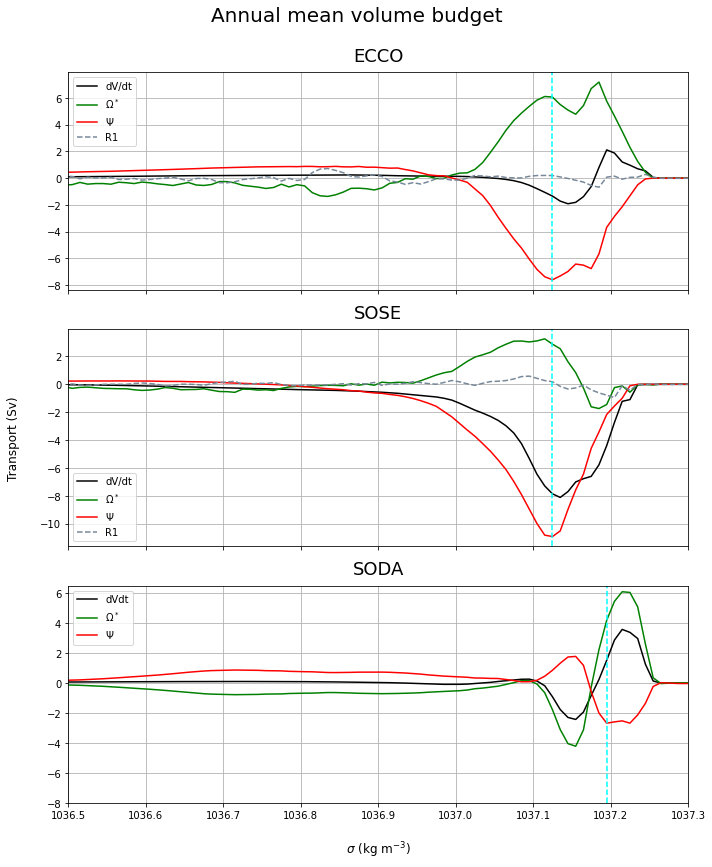

In [15]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1, figsize=(10,12), sharex=True)

(ecco.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
((ecco.omega_trans_rate+ecco.R2)/1e6).mean(dim='time').plot(label=r'$\Omega^*$', color='green', ax=ax0)
(ecco.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='red', ax=ax0)
#(ecco.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--', ax=ax0)
(ecco.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray', linestyle='--', ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel('')
ax0.legend()
ax0.grid()
ax0.set_title('ECCO', fontsize=18, pad=11)
ax0.set_xlim(1036.5, 1037.3)
ax0.axvline(x = 1037.125, color = 'cyan', linestyle='dashed')

(sose.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
((sose.omega_trans_rate+sose.R2)/1e6).mean(dim='time').plot(label=r'$\Omega^*$', color='green', ax=ax1)
(sose.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='red', ax=ax1)
#(sose.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--', ax=ax1)
(sose.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray', linestyle='--', ax=ax1)
ax1.set_ylabel(r'Transport (Sv)', fontsize=12, labelpad=20)
ax1.legend()
ax1.grid()
ax1.set_xlabel('')
ax1.set_title('SOSE', fontsize=18, pad=11)
ax1.set_xlim(1036.5, 1037.3)
ax1.axvline(x = 1037.125, color = 'cyan', linestyle='dashed')

(soda.dVdt/1e6).mean(dim='time').plot(label='dVdt', color='k', ax=ax2)
soda.omega_trans.mean(dim='time').plot(label=r'$\Omega^*$', color='green', ax=ax2)
soda.psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red', ax=ax2)
ax2.grid()
ax2.legend()
ax2.set_xlabel(r'$\sigma$ (kg m$^{-3}$)', fontsize=12, labelpad=20)
ax2.set_ylabel('')
ax2.set_ylim(-8,6.5)
ax2.set_xlim(1036.5, 1037.3)
ax2.set_title('SODA', fontsize=18, pad=11)
ax2.axvline(x = 1037.195, color = 'cyan', linestyle='dashed')

plt.suptitle('Annual mean volume budget', fontsize=20, y=1)
plt.tight_layout()
plt.savefig('time-mean-stacked.pdf');

## $\Omega$'s components

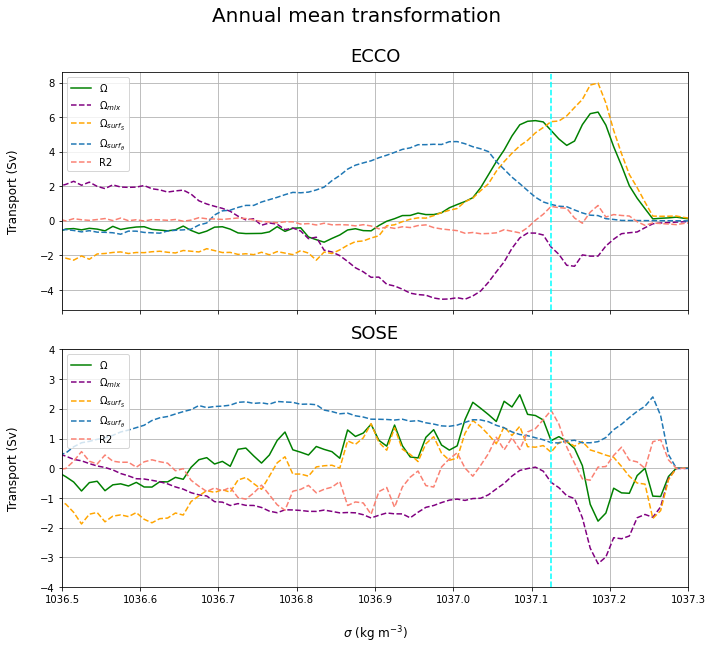

In [16]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(10,9), sharex=True)

(ecco.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green', ax=ax0)
(ecco.omega_mix/1e6).mean(dim='time').plot(label=r'$\Omega_{mix}$', color='purple', linestyle='dashed', ax=ax0)
(ecco.omega_surf_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_S}$', color='orange', linestyle='dashed', ax=ax0)
(ecco.omega_surf_th/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_\theta}$', color='C0', linestyle='dashed', ax=ax0)
(ecco.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--', ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel(r'Transport (Sv)', fontsize=12, labelpad=20)
ax0.legend()
ax0.grid()
ax0.set_title('ECCO', fontsize=18, pad=11)
ax0.set_xlim(1036.5, 1037.3)
ax0.axvline(x = 1037.125, color = 'cyan', linestyle='dashed')

(sose.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(sose.omega_mix/1e6).mean(dim='time').plot(label=r'$\Omega_{mix}$', color='purple', linestyle='dashed')
(sose.omega_surf_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_S}$', color='orange', linestyle='dashed')
(sose.omega_surf_th/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_\theta}$', color='C0', linestyle='dashed')
(sose.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--')
ax1.grid()
ax1.legend()
ax1.set_xlabel(r'$\sigma$ (kg m$^{-3}$)', fontsize=12, labelpad=20)
ax1.set_ylabel(r'Transport (Sv)', fontsize=12, labelpad=20)
ax1.set_ylim(-4,4)
ax1.set_xlim(1036.5, 1037.3)
ax1.set_title('SOSE', fontsize=18, pad=11)
ax1.axvline(x = 1037.125, color = 'cyan', linestyle='dashed');


plt.suptitle('Annual mean transformation', fontsize=20, y=1)
plt.tight_layout()
plt.savefig('time-mean-omegas-stacked.pdf');

## Bar view

In [6]:
bot_ecco = - (ecco.mean('time').isel(sigma2_bin=-1) - 
              ecco.mean('time').sel(sigma2_bin=1037.125, method='nearest'))
bot_sose = - (sose.mean('time').isel(sigma2_bin=-1) - 
              sose.mean('time').sel(sigma2_bin=1037.125, method='nearest'))
bot_soda = - (soda.mean('time').isel(sigma2_bin=-1) - 
              soda.mean('time').sel(sigma2_bin=1037.195, method='nearest'))

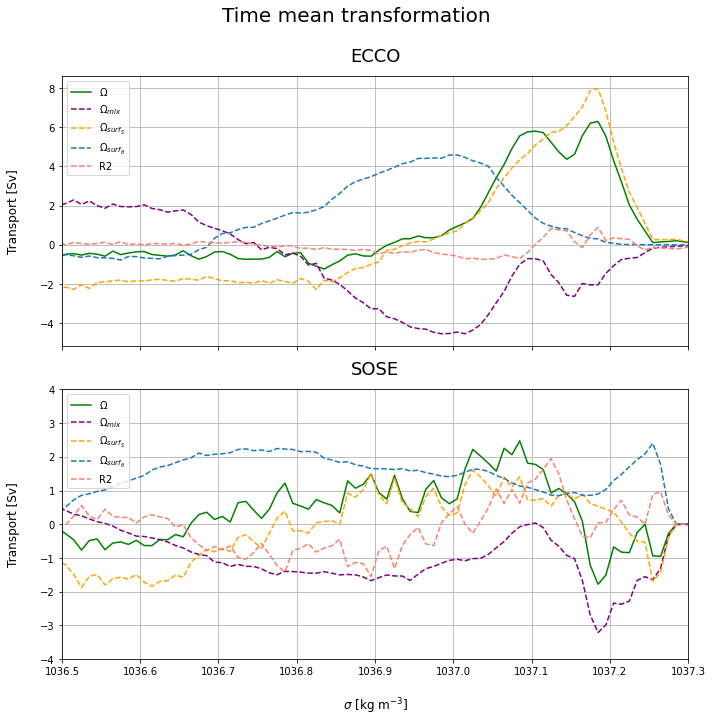

In [14]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(10,10), sharex=True)

(ecco.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green', ax=ax0)
(ecco.omega_mix/1e6).mean(dim='time').plot(label=r'$\Omega_{mix}$', color='purple', linestyle='dashed', ax=ax0)
(ecco.omega_surf_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_S}$', color='orange', linestyle='dashed', ax=ax0)
(ecco.omega_surf_th/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_\theta}$', color='C0', linestyle='dashed', ax=ax0)
(ecco.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--', ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel(r'Transport [Sv]', fontsize=12, labelpad=20)
ax0.legend()
ax0.grid()
ax0.set_title('ECCO', fontsize=18, pad=15)
ax0.set_xlim(1036.5, 1037.3)

(sose.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(sose.omega_mix/1e6).mean(dim='time').plot(label=r'$\Omega_{mix}$', color='purple', linestyle='dashed')
(sose.omega_surf_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_S}$', color='orange', linestyle='dashed')
(sose.omega_surf_th/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_\theta}$', color='C0', linestyle='dashed')
(sose.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--')
ax1.grid()
ax1.legend()
ax1.set_xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
ax1.set_ylabel(r'Transport [Sv]', fontsize=12, labelpad=20)
ax1.set_ylim(-4,4)
ax1.set_xlim(1036.5, 1037.3)
ax1.set_title('SOSE', fontsize=18, pad=15);


plt.suptitle('Time mean transformation', fontsize=20, y=1)
plt.tight_layout();

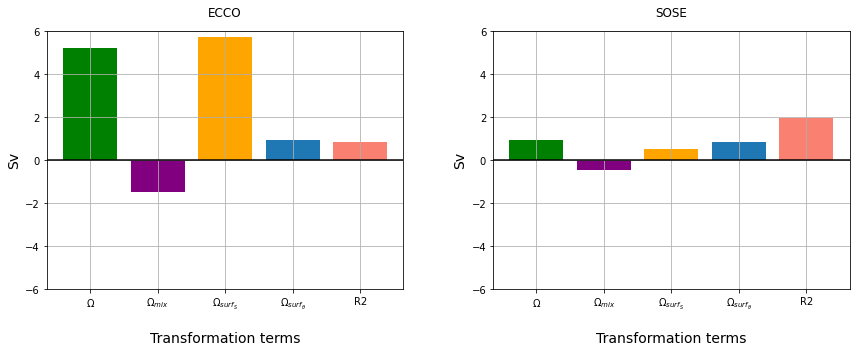

In [8]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\Omega$', height = bot_ecco.omega_trans_rate/1e6, color='green')
ax0.bar(x=r'$\Omega_{mix}$', height = bot_ecco.omega_mix/1e6, color='purple')
ax0.bar(x=r'$\Omega_{surf_S}$', height= bot_ecco.omega_surf_slt/1e6, color='orange')
ax0.bar(x=r'$\Omega_{surf_\theta}$', height= bot_ecco.omega_surf_th/1e6, color='C0')
ax0.bar(x='R2', height=bot_ecco.R2/1e6, color='salmon')
ax0.axhline(y=0, color='k')
ax0.set_title('ECCO', pad=15)
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('Transformation terms', fontsize=14, labelpad=20)
ax0.grid()
ax0.set_ylim(-6,6)

ax1.bar(x=r'$\Omega$', height = bot_sose.omega_trans_rate/1e6, color='green')
ax1.bar(x=r'$\Omega_{mix}$', height = bot_sose.omega_mix/1e6, color='purple')
ax1.bar(x=r'$\Omega_{surf_S}$', height= bot_sose.omega_surf_slt/1e6, color='orange')
ax1.bar(x=r'$\Omega_{surf_\theta}$', height= bot_sose.omega_surf_th/1e6, color='C0')
ax1.bar(x='R2', height=bot_sose.R2/1e6, color='salmon')
ax1.axhline(y=0, color='k')
ax1.set_title('SOSE', pad=15)
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('Transformation terms', fontsize=14, labelpad=20)
ax1.grid()
ax1.set_ylim(-6,6)

plt.tight_layout(w_pad=5);

In [9]:
bot_ecco.omega_surf_slt/1e6

<xarray.DataArray 'omega_surf_slt' ()>
array(5.71693837)

In [10]:
bot_sose.omega_surf_th/1e6

<xarray.DataArray 'omega_surf_th' ()>
array(0.86454794)

In [11]:
bot_sose.omega_surf_slt/1e6

<xarray.DataArray 'omega_surf_slt' ()>
array(0.53920375)

In [12]:
bot_sose.omega_mix/1e6

<xarray.DataArray 'omega_mix' ()>
array(-0.47423703)